📒 [NB 2-2] Vital Sign 이상치 탐지 및 보정
1. 데이터 생성 (이상치 포함)
수축기 혈압(SBP) 데이터를 생성한다. 생물학적으로 불가능한 값(Error)과 가능하지만 드문 값(Outlier)을 섞는다.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 가상의 혈압 데이터 20개 생성
# 정상 범위: 110 ~ 130
# 이상치: 180 (고혈압), 90 (저혈압)
# 오류값: 999 (기기 오류), -10 (입력 오류)
bp_data = [120, 118, 122, 115, 128, 130, 119, 121, 125, 110,
           180, 90, 175, 190, 85,  # 실제 발생 가능한 극단값 (Extreme Values)
           999, -10, 0, 300, 5]    # 물리적으로 불가능한 오류값 (Error)

df_bp = pd.DataFrame({'SBP': bp_data})

print("데이터 기초 통계량 (이상치 포함):")
# 평균이 999 등의 값 때문에 엉망이 된 것을 확인한다.
display(df_bp.describe())

데이터 기초 통계량 (이상치 포함):


,SBP
count,20.000000
mean,161.100000
std,208.976931
min,-10.000000
25%,105.000000
50%,120.500000
75%,141.250000
max,999.000000


2. 시각화를 통한 탐지 (Boxplot)
데이터의 분포를 그림으로 그리면 이상한 값이 순식간에 드러난다.

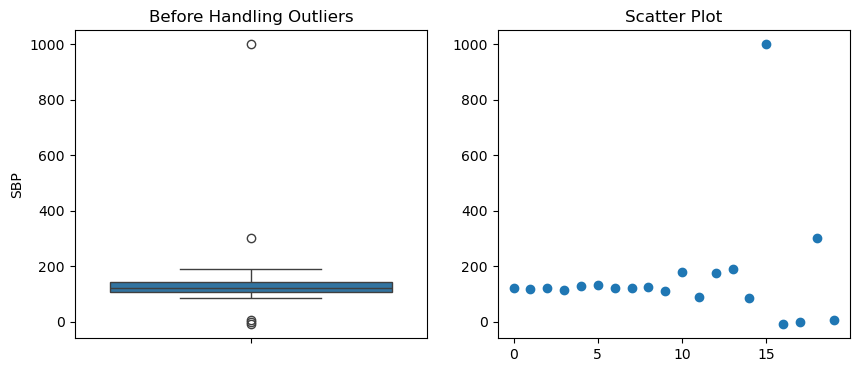

해석: 999와 음수 값 때문에 그래프가 납작해져 분포를 볼 수 없다.


In [2]:
plt.figure(figsize=(10, 4))

# 1. 박스 플롯 (Boxplot)
plt.subplot(1, 2, 1)
sns.boxplot(y=df_bp['SBP'])
plt.title("Before Handling Outliers")

# 2. 산점도 (Scatter Plot)
plt.subplot(1, 2, 2)
plt.plot(df_bp.index, df_bp['SBP'], 'o')
plt.title("Scatter Plot")

plt.show()
print("해석: 999와 음수 값 때문에 그래프가 납작해져 분포를 볼 수 없다.")

3. Rule-based 필터링 (오류 제거)
임상적 지식(Domain Knowledge)을 이용하여 물리적으로 불가능한 값을 먼저 제거한다.
가정: 수축기 혈압은 40보다 낮을 수 없고, 250보다 높을 수 없다(응급 상황 제외한 일반 검진 기준).

In [3]:
# 정상 범위(Physiological Range) 설정
MIN_BP = 40
MAX_BP = 250

# 조건에 맞지 않는 값을 NaN(결측) 처리하거나 제거한다.
# 여기서는 NaN으로 변환하여 '잘못된 값'임을 표시한다.
df_bp['SBP_Clean'] = df_bp['SBP'].apply(lambda x: x if MIN_BP <= x <= MAX_BP else np.nan)

print("물리적 오류 제거 후 데이터:")
# dropna()를 이용해 오류값 행을 날리고 확인한다.
display(df_bp.dropna())

물리적 오류 제거 후 데이터:


,SBP,SBP_Clean
0,120,120.0
1,118,118.0
2,122,122.0
3,115,115.0
4,128,128.0
5,130,130.0
6,119,119.0
7,121,121.0
8,125,125.0
9,110,110.0


4. 통계적 이상치 탐지 (IQR Method)
오류는 아니지만, 통계적으로 너무 튀는 값(예: 190, 85)을 찾아낸다.

In [4]:
# 오류가 제거된 데이터만 가지고 계산한다.
valid_data = df_bp['SBP_Clean'].dropna()

# 1. 사분위수 계산
Q1 = valid_data.quantile(0.25)
Q3 = valid_data.quantile(0.75)
IQR = Q3 - Q1

# 2. 이상치 경계(Threshold) 설정 (일반적으로 1.5 * IQR 사용)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"IQR: {IQR}")
print(f"정상 범위 하한선: {lower_bound:.2f}")
print(f"정상 범위 상한선: {upper_bound:.2f}")

# 3. 이상치 확인
outliers = valid_data[(valid_data < lower_bound) | (valid_data > upper_bound)]
print(f"\n통계적 이상치 목록:\n{outliers.values}")

IQR: 12.5
정상 범위 하한선: 97.75
정상 범위 상한선: 147.75

통계적 이상치 목록:
[180.  90. 175. 190.  85.]


5. 이상치 처리: 윈저라이징 (Winsorizing)
이상치를 삭제하지 않고, 상한선/하한선 값으로 대체하여 데이터의 손실을 막고 분석의 안정성을 높인다.

보정 전후 비교:


,Original(Cleaned),Winsorized
10,180.0,147.75
11,90.0,97.75
12,175.0,147.75
13,190.0,147.75
14,85.0,97.75


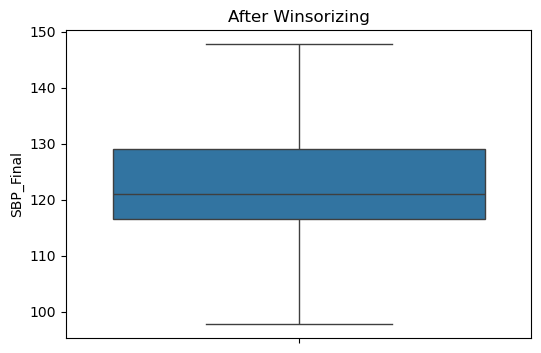

In [5]:
# 상한선을 넘으면 상한값으로, 하한선보다 낮으면 하한값으로 변경한다.
# (Clip 함수 사용)
df_bp['SBP_Final'] = df_bp['SBP_Clean'].clip(lower_bound, upper_bound)

print("보정 전후 비교:")
compare_df = pd.concat([valid_data.reset_index(drop=True),
                        df_bp['SBP_Final'].dropna().reset_index(drop=True)], axis=1)
compare_df.columns = ['Original(Cleaned)', 'Winsorized']
display(compare_df.tail(5)) # 끝부분의 이상치들이 보정된 것을 확인

# 최종 분포 확인
plt.figure(figsize=(6, 4))
sns.boxplot(y=df_bp['SBP_Final'])
plt.title("After Winsorizing")
plt.show()